NOTE: Before running, __go to the last cell__ and run that first.

The Excel file loaded in the next line is from L1Base (v2), a database containing active LINE-1 (L1) insertions residing in human genomes. (http://l1base.charite.de ). The 'hot' L1s here are referenced to hg38. 

In [1]:
import pandas as pd
import seaborn
plot_dict = {} # for the histogram plot at the end of this notebook. initialized once.

In [2]:
l1base_df = pd.read_excel('../../data/l1base/l1base_hsfli_8438.xlsx')

l1base_list = []
for index, row in l1base_df.iterrows():
    l1base_list.append([row[0], row[1], row[2], row[5], row[6], row[7], row[8], row[9]])

headers = ['Chr','Start','End','Strand','ORF1 Start','ORF1 End','ORF2 Start','ORF2 End']
l1base_df = pd.DataFrame(l1base_list, columns=headers)

The function below slices the contents of the Excel file, by chromosome. 

In [3]:
def slice_df_by_chrom(df, fields):
    '''
    Slice a dataframe by chromosome.

    :param probe: A dataframe object loaded from l1base_hsfli_8438.xlsx file.
    :return: A dictionary of L1 locations keyed by chromosome. 
    '''
    chr_positions = {}
    for chr in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,22,'X','Y']: # chr number
        chr_positions[chr] = df.loc[df['Chr']==chr][fields] # slice df
    return chr_positions

In [4]:
# include the following headings in the sliced object
headings = ['Start', 'End', 'ORF1 Start', 'ORF1 End', 'ORF2 Start', 'ORF2 End']

chr_dict = slice_df_by_chrom(l1base_df, headings)

ch='X' # which chromosome? ----- Note: this sets 'ch' for the entire noteboook. 

print ('Active L1s in chromosome {n}: '.format(n=ch))
L1chr = chr_dict[ch]
L1chr

Active L1s in chromosome X: 


,Start,End,ORF1 Start,ORF1 End,ORF2 Start,ORF2 End
132,11706247,11714295,1908,2921,2988,6812
133,23237515,23245560,1907,2920,2987,6811
134,142476843,142484883,1909,2919,2986,6810
135,155523050,155515003,1909,2922,2989,6813
136,141428248,141420202,1908,2921,2988,6812
137,96064845,96056798,1909,2922,2989,6813
138,83066639,83058591,1909,2922,2989,6813
139,64020288,64012236,1909,2922,2989,6813
140,54125747,54117700,1909,2922,2989,6813
141,47790701,47782657,1909,2922,2989,6810


Load the methyl object for TCGA-33-4586. 

In [7]:
obj = 'TCGA-50-5931-LUAD'
TCGA_object = load_obj(obj)

loading TCGA-50-5931-LUAD ...


In [8]:
probe_keys = sorted(TCGA_object.keys()) # probe keys are 'cg00000029', etc.

chr_probes = [] # stores a list of probe keys by chromosome. 

for probe in probe_keys:
    if TCGA_object[probe].chr == str(ch):
        chr_probes.append(probe)
len(chr_probes) # number of probes belonging to this chromosome.

6250

In [9]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

In [10]:
L1 = sorted([TCGA_object[probe].hg38_cord for probe in chr_probes]) # loci of TCGA methyl object
L2 = sorted(L1chr['End']) # end loci of each LINE-1 (or mid point between start and end?) 

L1 = list(filter((-1).__ne__, L1)) # remove -1's, WTF?

L1_minmax = minmax(L1) # a tuple containing the min and max of the TCGA methyl object.
L2_minmax = minmax(L2) # a tuple containing the min and max of the LINE-1 object.

In [11]:
print ( 'L1: {_L1}, L2: {_L2}'.format(_L1=L1_minmax, 
                                      _L2=L2_minmax) ) 

L1: (2796977, 155616255), L2: (11714295, 155515003)


Get the index of the next number between minmax of L1 that is greater than or equal to min of L2.

In [12]:
# <expression1> if <condition> else <expression2>

for number in L1:
    if number < L2[0]:
        continue
    if number == L2[0]:
        print (L1.index(number))
        break
    else:
        if number > L2[0]:
            print ('Index: {i}, Locus: {n}.'.format(i=L1.index(number), 
                                             n=L1[L1.index(number)]))
            break

Index: 217, Locus: 11755348.


Starting from the L1 index above, find all probes that are __within range of L2__. First, remove all elements in L1 that are to the left of index 8599 (that are less than the starting index in L2).  

In [13]:
L1.index(number), L1.index(L1[-1]) # elements in l1 that are in range. 

(217, 6201)

In [14]:
indexes = range(L1.index(number), L1.index(L1[-1])) # a range of sorted probes in L1

new_indexes = []
for idx in indexes:
    if L1[idx] >= minmax(L2)[1]: # probe index value is greater than greatest of L1's?
        break
    new_indexes.append(L1[idx])  # if not, add it to the new list. 

In [15]:

try:
    
    assert (new_indexes[0] > minmax(L2)[0] and new_indexes[-1] < minmax(L2)[1])
    
    ratio = ((len(new_indexes) / len(chr_probes)) * 100)
    ratio = round(ratio, 2)
    plot_dict[ch] = ratio
    print ('{nl} methylated probes ({r}%) overlap active LINE-1 loci in Chr{c} for {o}.'.format(
                                            nl=len(new_indexes),
                                            r=ratio,
                                            c=ch,
                                            o=obj) )
except IndexError:
    print ('0 probes (0%) overlap active LINE-1s in Chr{c} for {o}.'.format(
                                            c=ch,
                                            o=obj) )




5976 methylated probes (95.62%) overlap active LINE-1 loci in ChrX for TCGA-50-5931-LUAD.


In [16]:
plot = {'1': 51.6, '2': 65.6, '3': 79.5, '4': 60.9, '5': 73.1, '6': 87.0,
 '7': 56.8, '8': 29.4, '9': 30.1, '10': 65.0, '11': 55.7, '12': 49.0,
 '13': 13.0, '14': 34.7, '15': 54.0, '16': 56.7, '17': 0.0, '18': 47.4,
 '20': 2.5, '22': 59.4, 'X': 95.6, 'Y': 0.0}

The values plotted below are for one cancer type (LUAD) and represent one paired experiment. However the pattern is similar for other types and experiments.

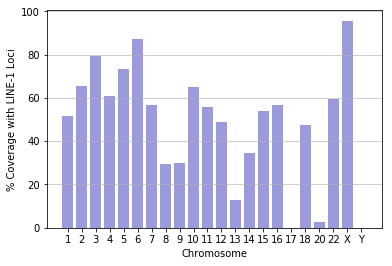

In [18]:
import matplotlib.pyplot as plt 

plt.bar(range(len(plot)), list(plot.values()), color='#0504aa', alpha=0.4, align='center')
plt.grid(axis='y', alpha=0.75)
plt.xticks(range(len(plot)), list(plot.keys()))
plt.xlabel('Chromosome')
plt.ylabel('% Coverage with LINE-1 Loci')
plt.show()

The plot shows relative coverage of 'methylated' Illumina 450k probes with LINE-1 L1Base data (by chromosome). ~50% of 450k probes for chromosome 1 overlap with loci found in the L1Base data for LINE-1, ~95% overlap for Chr X.   

In [19]:
content = []
eul1db_srip_list = []
headers = ['Chr','Start','End', 'Strand']

with open("../../data/eul1db-data/eul1db_srip.bed")as f:
    for line in f:
        content.append(line.strip().split())
for i, line in enumerate(content):
    if i < 3:
        continue
    eul1db_srip_list.append([line[0][3:], line[1], line[2], line[5]])
eul1db_srip_df = pd.DataFrame(eul1db_srip_list, columns=headers)

In [20]:
eul1db_srip_df.head(5)

,Chr,Start,End,Strand
0,1,815511,815511,-
1,1,980069,980069,+
2,1,1149273,1149273,-
3,1,1687509,1687509,-
4,1,3053277,3053277,-


In [6]:
# %load '../methylator/annotation/annotate_450k.py'
import os

class Probe:
    """
    Holds Illumina 450k probe info for a single CpG site.
    """
    def __init__(self):
        self.id = None
        self.seq = None
        self.name = None
        self.chr = None
        self.hg19_cord = None
        self.strand = None
        self.gene = None
        self.refseq = None
        self.tour = None
        self.feature = None
        
class Interval:
    """
    Define a genomic interval by chromsome and strand orientation.
    """
    def __init__(self, chromosome, start, end, strand):
        self.chr = chromosome
        self.start = start
        self.end = end
        self.strand = strand

class Feature:
    """
    Define a Probe feature.
    """
    BODY = "Body"
    TSS200 = "TSS200"
    TSS1500 = "TSS1500"
    UTR5 = "5'UTR"
    UTR3 = "3'UTR"
    EXON = "Exon"

class CpG_location:
    """
    Defines a CpG location.
    """
    ISLAND = "Island"
    NSHORE = "N_Shore"
    SSHORE = "S_Shore"
    NSHELF = "N_Shelf"
    SSHELF = "S_Shelf"
    
class SNP:
    """
    Defines the SNPs in probes. Used to filter probes.
    """

    def __init__(self):
        self.probeid = None
        self.snpid = None
    
class Annotate_450k:
    """
    Parse and hold information about Illumina probes.
    """

    def __init__(self):        
        for i in open(anno_file, mode="r"):
            self.ann = os.path.join("../../data/", i.strip("\n").strip("\r"))

        self.probe = {}
        self.__run__()

    def __run__(self):
        """
        A static function to setup the Probe classes.
        """
        for i in open(self.ann, mode="r"):
            if i.startswith("cg"):
                data = i.split(",")
                # Assign probe information.
                new_probe = Probe()
                new_probe.id = data[0]                 # ID
                new_probe.name = data[1]               # name
                new_probe.seq = data[13]               # sequence prior to bi-sulfite conv.
                new_probe.chr = str(data[11])          # chromosome
                new_probe.hg19_cord = int(data[12])    # chromosomal coordinates of the CpG.
                new_probe.strand = data[16]            # strand
                new_probe.gene = data[21].split(";")   # UCSC_RefGene_Name
                new_probe.refseq = data[22]            # UCSC_RefGene_Accession
                features = data[23].split(";")         # UCSC_RefGene_Group
                list_features = []
                for i in features:
                    if i not in list_features:
                        list_features.append(i)

                new_probe.feature = list_features

                new_probe.tour = data[25]              # Relation_to_UCSC_CpG_Island
                newcpg = {new_probe.id: new_probe}
                self.probe.update(newcpg)

    def get_number(self):
        """
        Return total number of probes.
        """
        number = 0
        for probe_id in self.probe.keys():
            number += 1

        return number

    def get_probe(self, probe_id): #WORKS
        """
        Return probe info associated with an reference.
        """
        try:
            probe = self.probe[probe_id]
        except Exception as ex:
            probe = None
            print("WARNING: No probe with ref-id of %s found." % probe_id)
        return probe

    def remove_snp_probes(self):
        """
        Removes all SNPs associated with probes.
        """
        snp_list = []
        snp_file = open("../../data/humanmethylation450_dbsnp137.snpupdate.table.v2.sorted.txt", "r")
        for line in snp_file:
            if line.startswith("cg"):
                line = line.strip("\n").strip("\r").split("\t")
                new_snp = SNP()
                new_snp.probeid = line[0]
                new_snp.snpid = line[1]
                snp_list.append(new_snp)

        for snp in snp_list:
            self.probe.pop(snp.probeid)

anno_file = os.path.abspath("../../data/config.ini") # Illumina probe manifest. Note: This (large) file is not 
                                                     # in the repository.
# Functions to save/load dictionary objects. 

import _pickle as pickle

def save_obj(obj, name):
    print('saving ' + name + ' ...')
    with open('../../data/pickle/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    print('loading ' + name + ' ...')
    with open('../../data/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)